# Классификация изображений цифр метрическими методами


## Реализация алгоритмов 

Среди предоставленных файлов есть следующие модули и функции в них

1. Модуль `knn.distances` с реализацией функции для вычисления расстояния:
    1. `euclidean_distance(X, Y)` — реализация евклидова расстояния с заданными свойствами;
    2. `cosine_distance(X, Y)` — реализация косинусного расстояния с заданными свойствами;


2. Модуль `knn.nearest_neighbors`, содержащий собственную реализацию поиска ближайших соседей.
    
    Класс `NearestNeighborsFinder` с методами:
      1. `__init__(self, n_neighbors, metric="euclidean")` — конструктор (инициализатор) класса;
      2. `fit(self, X, y=None)` — обучение алгоритма;
      3. `kneighbors(self, X, return_distance=False)` — поиск ближайших соседей.


3. Модуль `knn.classification`, содержащий собственную реализацию классификатора на основе метода ближайших соседей.

    Класс `KNNClassifier` с методами:
    
    1. `__init__(self, n_neighbors, algorithm=’my_own’, metric=’euclidean’, weights=’uniform’)` — конструктор (инициализатор) класса;
    2. `fit(self, X, y=None)` — обучение алгоритма;
    3. `kneighbors(self, X, return_distance=False)` — поиск ближайших соседей;
    4. `predict(self, X)` — редсказание на новых данных;
    5. `_predict_precomputed(self, indices, distances)` — вспомогательный метод.
    
   Класс `BatchedKNNClassifier`, полезный для работы с большими выборками, с методами:
   
    1. `__init__(self, n_neighbors, algorithm=’my_own’, metric=’euclidean’, weights=’uniform’, batch_size=None)` — конструктор (инициализатор) класса
    2. `kneighbors(self, X, return_distance=False)` — поиск ближайших соседей, разбитый на несколько итераций по батчам
    3. `set_batch_size(self, batch_size)` — метод для выставления нового значения размера батча


4. Модуль `knn.model_selection` с реализациями функций для применения кросс-валидации:

    1. `knn_cross_val_score(X, y, k_list, scoring, cv=None, **kwargs)` — функция для измерения качества на кросс-валидации.

## Эксперименты


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.datasets
import pandas as pd
import time
from tqdm import tqdm
from collections import defaultdict


from knn.distances import euclidean_distance, cosine_distance
from sklearn.model_selection import KFold
from knn.classification import BatchedKNNClassifier
from knn.model_selection import knn_cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### 1. Загрузка даннных

Эксперименты проводятся на датасете MNIST.
http://yann.lecun.com/exdb/mnist/. 

In [2]:
X, y = sklearn.datasets.fetch_openml("mnist_784", version=1, return_X_y=True)

In [3]:
train_size = 60000
seed = 0xAB0BA
np.random.seed(seed)

x_train = X[:train_size].to_numpy()
y_train = y[:train_size].to_numpy().astype(int)
x_test = X[train_size:].to_numpy()
y_test = y[train_size:].to_numpy().astype(int)

### 2. Исследование скорости методов поиска 

Исследуем, какой алгоритм поиска ближайших соседей будет быстрее работать в различных ситуациях.

Измерим для каждого алгоритма поиска (`kd_tree`, `ball_tree`, `brute` и `my_own`) время нахождения 5 ближайших соседей для каждого объекта тестовой выборки по евклидовой метрике. Выберем подмножество признаков, по которому будет считаться расстояние, размера 10, 20, 100 (подмножество признаков выбирается один раз для всех объектов, случайно).


In [4]:
features_sizes = [10, 20, 100]
finders = ["kd_tree", "ball_tree", "brute", "my_own"]
n_neighbors = 5
batch_size = 128
result_dict = defaultdict(float)

In [58]:
def alg_measure(x_train, y_train, x_test, alg):
    start = time.time()
    knn = BatchedKNNClassifier(n_neighbors, algorithm=alg, batch_size=batch_size)
    knn.fit(x_train, y_train)
    result = knn.kneighbors(x_test)
    end = time.time()

    return end - start


for size in tqdm(features_sizes):
    features = np.random.choice(range(x_train.shape[1]), size)
    x_train_temp = x_train[:, features]
    x_test_temp = x_test[:, features]

    for alg in finders:
        result = alg_measure(x_train_temp, y_train, x_test_temp, alg)

        if alg not in result_dict.keys():
            result_dict[alg] = np.array(result)
        else:
            curr_time = result_dict[alg]
            curr_time = np.append(curr_time, result)
            result_dict[alg] = curr_time

100%|██████████| 3/3 [04:27<00:00, 89.02s/it] 


In [3]:
# здесь я сохранялся, потому что нужно было убегать, сори за мусор
# np.save('time_dict.npy', result_dict)
time_dict = np.load("time_dict.npy", allow_pickle="TRUE").item()

#### Приведем график с результатами вашего эксперимента

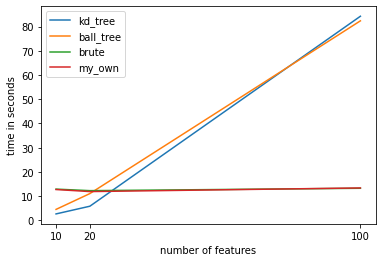

In [13]:
for key in time_dict.keys():
    plt.plot(features_sizes, time_dict[key], label=key)
    plt.xticks(features_sizes)
    plt.xlabel("number of features")
    plt.ylabel("time in seconds")
    plt.legend()

#### Результаты

1. Какой алгоритм сработал быстрее всего для каждого из размера подвыборок? 

На маленьких размеров подвыборок быстрее работает несомненно деревья, так как им удается успешно и довольно быстро разделять все объекты по кластерам, с увеличением признаков до 100 условный поиск разделяющего параметра на 100-мерном пространстве для всех объектов становится несколько более затруднительной операцией. На самом деле, было понятно, что на маленьких подвыборках обычное дерево точно будет выигрывать, про остальные не совсем, на большом количестве признаков казалось, что в склерне есть крутая и быстрая реализация всего этого, которая позволит все равно быть быстрее брутфорса, но как видим это не так.

2. Какой алгоритм исходя из результатов эксперимента следует использовать в дальнейшем?

Далее будем использовать либо брутфорс, либо собственный алгоритм, что в целом одно и то же почти)

### 3. Исследование зависимости точности алгоритма на кросс-валидации 


Оценитим по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) алгоритма k ближайших соседей в зависимости от следующих факторов:
* количество соседей k от 1 до 10
* используется евклидова или косинусная метрика

In [17]:
k_list = np.arange(1, 11)
metrics = ["euclidean", "cosine"]
cv = KFold(n_splits=3)

In [13]:
ec = knn_cross_val_score(
    x_train,
    y_train,
    k_list,
    scoring="accuracy",
    cv=cv,
    metric="euclidean",
    batch_size=64,
)
# np.save('acc_euclidean_dict.npy', ec)
cs = knn_cross_val_score(
    x_train, y_train, k_list, scoring="accuracy", cv=cv, metric="cosine", batch_size=64
)
# np.save('acc_cosine_dict.npy', cs)

#### Нарисуем график зависимости точности от количества соседей по каждой метрике

In [14]:
# cs = np.load('acc_cosine_dict.npy',allow_pickle='TRUE').item()
# ec = np.load('acc_euclidean_dict.npy',allow_pickle='TRUE').item()

In [15]:
for key in ec.keys():
    ec[key] = np.mean(ec[key])

for key in cs.keys():
    cs[key] = np.mean(cs[key])

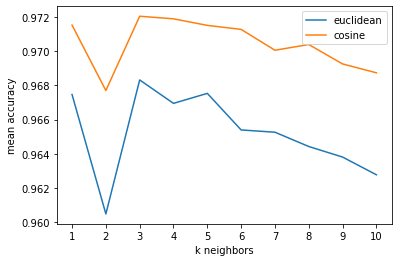

In [19]:
plt.plot(k_list, ec.values(), label="euclidean")
plt.plot(k_list, cs.values(), label="cosine")
plt.xticks(k_list)
plt.xlabel("k neighbors")
plt.ylabel("mean accuracy")
plt.legend()

#### Результаты

1. Оптимальность гиперпараметров

Наиболее оптимальные гиперпараметры - 3 соседа по косинусному расстоянию. Качество самое высокое, достаточно соседей, следовательно не так много расчетов, а качество все еще хорошее.

2. Наилучшая метрика

Косинусная метрика оказалась лучше, потому что она опирается на угол между векторами, а не величину векторов. В случае с картинками и многомерными векторами, это будет иметь смысл в нахождении соседей
    
   
3. Зависимости точности от количество соседей, "выбросы", резкие падения/повышения качества для одного значения k по сравнению с соседними

Есть резкое падение на 2 соседях, хотя качество остается высоким. Тем не менее, можно предположить, что когда есть два соседа, то возникают плохие случаи, когда рядом с объектом лежит объект другого класса и тогда просто выбирается наименьший класс. И далее с увеличением соседей качество начинает падать, это связано с тем, что границы каждого класса могут быть разной формы, и при большом количестве соседей некоторые небольшие кластеры одного класса уже будут перекрываться другим классом

### 3. Исследование зависимости точности взвешенного алгоритма на кросс-валидации 

По результатам предыдущего эксперимента выберем метрику, которую будем использовать в этом эксперименте.

Оценим по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) взвешенного алгоритма k ближайших соседей в зависимости от количество соседей k (от 1 до 10).

Голос объекта положим равным `1 / (distance + eps)`, где `eps` = `1e-5`.

In [5]:
k_list = np.arange(1, 11)
metric = "cosine"
cv = KFold(n_splits=3)
weights = "distance"

In [6]:
weighted_res = knn_cross_val_score(
    x_train,
    y_train,
    k_list,
    scoring="accuracy",
    cv=cv,
    metric=metric,
    weights=weights,
    batch_size=64,
)

In [7]:
for key in weighted_res.keys():
    weighted_res[key] = np.mean(weighted_res[key])

#### Нарисуем график зависимости точности от количества соседей 

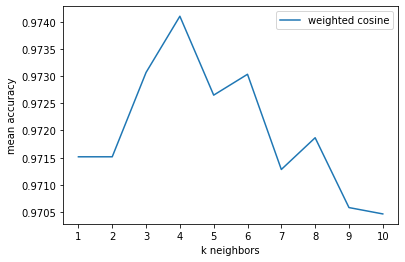

In [9]:
plt.plot(k_list, weighted_res.values(), label="weighted cosine")
plt.xticks(k_list)
plt.xlabel("k neighbors")
plt.ylabel("mean accuracy")
plt.legend()

#### Результаты

1. Оптимальные гиперпараметры

По качеству и количеству соседей - 4. Наивысшее качество, приемлемое кол-во вычислений


2. Сравнение результатов взвешенного алгоритма с невзвешенным.

Максимум во взвешенном больше, это может достигаться на тех случаях, когда небольшой кластер близко лежащих объектов по количеству перекрывается объектами другого класса. Во взвешенном случае, близкие объекты дают больший вес и соотвтетсвенно такая ошибка может устраняться

### 4. Применение алгоритма и интерпретация ошибок

1. Применим лучший алгоритм к исходной обучающей и тестовой выборке и посчитаем точность классификации. Сравним с точностью по кросс-валидации.

In [10]:
knn = BatchedKNNClassifier(
    n_neighbors=4, metric="cosine", weights="distance", batch_size=64
)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

In [11]:
accuracy_score(y_pred, y_test)

0.9752

Результаты радуют глаз, лучше чем на кросс валидации. Полагаю, что это связано с тем, что мы расширили обучающую выборку, а также в наших тестах бралось среднее

2. Построем и проанализируем матрицу ошибок (confusion matrix)

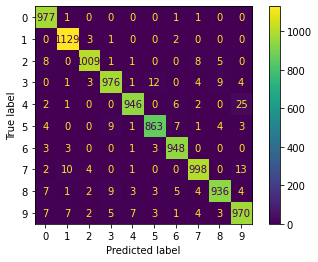

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

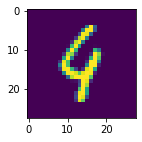

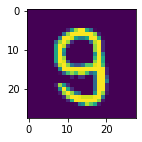

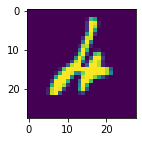

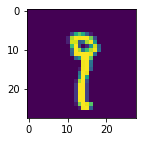

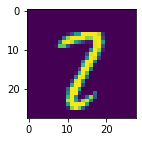

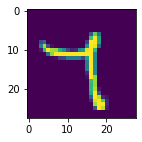

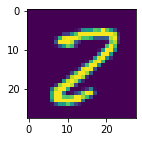

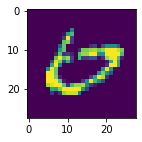

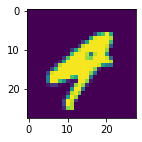

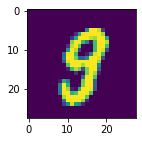

In [20]:
for obj in (x_test[(y_pred != y_test)])[:10]:
    img = obj.reshape(28, 28)
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    ax.imshow(img)
    plt.show()

Видно, что классификатор довольно редко путает обекты. часто путается 3 и 5 объект, а также 4 и 9, 7 и 9

##  Размножение обучающей выборки

Размножим обучающую выборку с помощью поворотов, смещений, применений гауссовского фильтра и морфологических операций. 
1. Величина поворота: 5, 10, 15 (в каждую из двух сторон)
2. Величина смещения: 1, 2, 3 пикселя (по каждой из двух размерностей)
3. Дисперсия фильтра Гаусса: 0.5, 1, 1.5
4. Морфологические операции: эрозия, дилатация, открытие, закрытие с ядром 2



Так как все вместе подбирать это очень долго, слишком много комбинаций, то мы будет осуществляться перебор последовательно. 

In [4]:
import random
import albumentations as A
from skimage import transform
import cv2
from tqdm import tqdm
import scipy.ndimage as ndimage

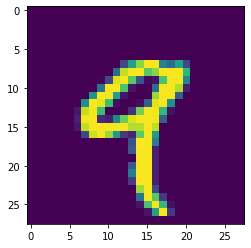

In [117]:
img = x_train[4].reshape(28, 28)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(img)
# смешная цифра

In [6]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train, y_train)

In [5]:
def create_new_train(x_train, y_train, radians=None, shift_num=None):
    new_objs = []
    new_objs_y = []

    for i, obj in tqdm(enumerate(x_train)):
        objs_y = y_train[i]
        img = obj.reshape(28, 28)
        if not radians == None:
            transformed_1 = transform.rotate(img, radians, resize=False)
            transformed_2 = transform.rotate(img, radians, resize=False)
            new_objs.append(np.ravel(transformed_2))
            new_objs_y.append(objs_y)
        elif not shift == None:
            transformed_1 = ndimage.shift(img, [shift_num, shift_num])
        new_objs.append(np.ravel(transformed_1))
        new_objs_y.append(objs_y)

    new_x_train = np.vstack((x_train, np.vstack(new_objs)))
    new_y_train = np.hstack((y_train, np.array(new_objs_y)))

    return new_x_train, new_y_train

In [7]:
radians_transform = [5, 10, 15]
radians_transform_acc = {}

for radian in radians_transform:
    new_x_train, new_y_train = create_new_train(x_train1, y_train1, radians=radian)
    knn = BatchedKNNClassifier(
        n_neighbors=4, metric="cosine", weights="distance", batch_size=64
    )
    knn.fit(new_x_train, new_y_train)
    y_pred = knn.predict(x_test1)
    radians_transform_acc[radian] = accuracy_score(y_test1, y_pred)

45000it [00:10, 4417.91it/s]
45000it [00:11, 3961.54it/s]
45000it [00:11, 4012.39it/s]


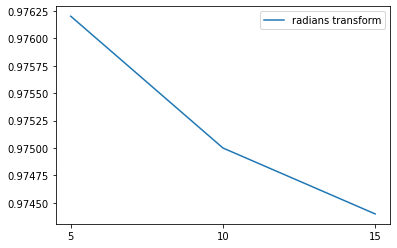

In [8]:
plt.plot(radians_transform, radians_transform_acc.values(), label="radians transform")
plt.xticks(radians_transform)
plt.legend()

# итоговое качество после поворотов - 0.97625

45000it [00:10, 4441.86it/s]


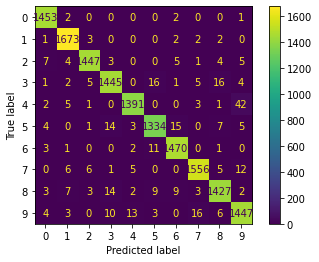

In [10]:
new_x_train, new_y_train = create_new_train(x_train1, y_train1, radians=5)
knn = BatchedKNNClassifier(
    n_neighbors=4, metric="cosine", weights="distance", batch_size=64
)
knn.fit(new_x_train, new_y_train)
y_pred = knn.predict(x_test1)
radians_transform_acc[radian] = accuracy_score(y_test1, y_pred)

cm = confusion_matrix(y_test1, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Если сравнить с прошлой, то остались все те же ошибки, алгоритм путает 4 и 9, 7 и 9, но немного ушли остальные небольшие ошибки, которые были. Там, где мы их почти не встречали, следовательно мы покрыли какие то крайние случаи. Оставим теперь поворот на 5, так как он лучший в качестве

In [11]:
x_train, y_train = create_new_train(x_train, y_train, radians=5)

60000it [00:15, 3833.00it/s]


In [12]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train, y_train)

In [13]:
shift_list = [1, 2, 3]
shift_dict_acc = {}

for shift in shift_list:
    new_x_train, new_y_train = create_new_train(x_train1, y_train1, shift_num=shift)
    knn = BatchedKNNClassifier(
        n_neighbors=4, metric="cosine", weights="distance", batch_size=64
    )
    knn.fit(new_x_train, new_y_train)
    y_pred = knn.predict(x_test1)
    shift_dict_acc[shift] = accuracy_score(y_test1, y_pred)

135000it [00:12, 10690.84it/s]
135000it [00:13, 9704.63it/s]
135000it [00:13, 9857.14it/s] 


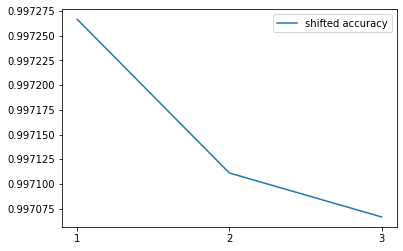

In [14]:
plt.plot(shift_list, shift_dict_acc.values(), label="shifted accuracy")
plt.xticks(shift_list)
plt.legend()

# Итоговое качество после смещения - 0.997275

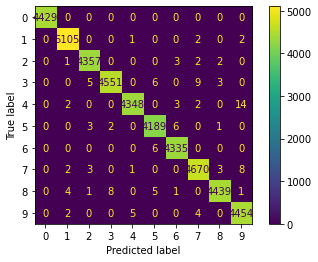

In [16]:
new_x_train, new_y_train = create_new_train(x_train1, y_train1, shift_num=1)
knn = BatchedKNNClassifier(
    n_neighbors=4, metric="cosine", weights="distance", batch_size=64
)
knn.fit(new_x_train, new_y_train)
y_pred = knn.predict(x_test1)
shift_dict_acc[shift] = accuracy_score(y_test1, y_pred)


cm = confusion_matrix(y_test1, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Как видим мы решили некоторые ошибки, которые были. Например стало значительно меньше ошибок 7 и 9